<h1 style="text-align: center;">Tennis Analyzer ML Model V2</h1>
<h3 style="text-align: center;">Dan Warnick</h3>

<p>To start we will begin by selecting the data points we want to analyze with existing known results. For each data entry we will have two players each with the following data entries.</p>
<table style="font-size: .8em;">
    <tr>
        <th>Player Name</th>
    </tr>
</table>
<p>Along with match facts like Clay/Hard/Grass Court or Indoor/Outdoor. In the future may want to add weather and adjust certain parameters for more accuracy and more data points to train from, however for now this seems a good start.</p>

<h2>1.) Collect Data Efficiently</h2>

In [1]:
import django
from django.http import HttpResponse
from django.template import loader
import os
from django.db import models
import torch
from math import ceil, floor
import math
import numpy as np
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.utils as utils
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
from datetime import datetime
from asgiref.sync import sync_to_async # type: ignore
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score
import copy
import joblib
import lightgbm as lgb
import shap
from optuna.integration import lightgbm as lgb_optuna

from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

# os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'breakpoint.settings')
# django.setup()

# from render.models import *

In [2]:
start = '20120101'
end = '20231231'
match_type = 'm'

In [3]:
start_date = datetime.strptime(start, '%Y%m%d').date()
end_date = datetime.strptime(end, '%Y%m%d').date()

# if match_type == 'm':   
#     typer = MensTennisMatch
#     insert_db = MensTennisMatchStats
# else:
#     typer = WomensTennisMatch
#     insert_db = WomensTennisMatchStats

# query = insert_db.objects.filter(
#         tourney_date__range=(start_date, end_date)
#     ).order_by('tourney_date')
    
# games = await sync_to_async(list)(query.all().values())

RD_CUTOFF = 125

df = pd.read_csv('../testcsvs/glickoUpdatedTest.csv')
df['tourney_date'] = pd.to_datetime(df['tourney_date']).dt.date
df = df[(df['tourney_date'] >= start_date) & (df['tourney_date'] <= end_date)]
df = df[(df['a_surface_glicko_rd'] <= RD_CUTOFF) & (df['b_surface_glicko_rd'] <= RD_CUTOFF) & (df['a_glicko_rd'] <= RD_CUTOFF) & (df['b_glicko_rd'] <= RD_CUTOFF)]
df = df[~(df == -20).any(axis=1)]


df = df.drop(['tourney_id', 'tourney_name', 'match_num', 'tourney_date', 'a_player_name', 'b_player_name', 'a_player_id', 'a_player_slug', 'b_player_id', 'b_player_slug', 'sets', 'a_b_win', 'tiebreaks'], axis=1)



# df = pd.DataFrame(games).drop(['tourney_id', 'tourney_name', 'tourney_date', 'a_player_name', 'b_player_name', 'a_player_id', 'a_player_slug', 'b_player_id', 'b_player_slug','a_win_percent', 'a_serve_rating', 'a_return_rating', 'a_pressure_rating', 'a_avg_vs_elo', 'a_matches_played', 'b_win_percent', 'b_serve_rating', 'b_return_rating', 'b_pressure_rating', 'b_avg_vs_elo', 'b_matches_played', 'A_Odds', 'b_odds'], axis=1)

one_hot_encoder = OneHotEncoder(sparse_output=False)

# One-Hot Encode the 'category_text' column
category_encoded = one_hot_encoder.fit_transform(df[['surface']])

# Convert to DataFrame
category_encoded_df = pd.DataFrame(category_encoded, columns=one_hot_encoder.get_feature_names_out(['surface']))

# Concatenate the one-hot encoded columns back to the original DataFrame
df = pd.concat([df, category_encoded_df], axis=1)

# Drop the original 'category_text' column
df.drop('surface', axis=1, inplace=True)
print(len(df))

28748


In [4]:
df.head()

,best_of,tourney_round,a_player_age,a_player_rank,a_player_rank_points,b_player_age,b_player_rank,b_player_rank_points,rank_diff,rank_points_diff,...,a_surface_return_second_won_glicko_rating,b_surface_second_won_glicko_rating,a_surface_return_second_won_glicko_rd,b_surface_second_won_glicko_rd,games,a_odds,b_odds,surface_Clay,surface_Grass,surface_Hard
5373,3.0,0.8,28.0,74.0,671.0,23.0,15.0,1925.0,59.0,-1254.0,...,1509.676357,1525.177533,64.968960,61.353283,0.0,3.59,1.28,0.0,1.0,0.0
5375,3.0,0.8,25.0,46.0,920.0,28.0,65.0,755.0,-19.0,165.0,...,1493.441526,1520.481105,70.605742,62.024125,1.0,NaN,NaN,0.0,1.0,0.0
5378,3.0,0.8,26.0,83.0,640.0,24.0,48.0,915.0,35.0,-275.0,...,1506.545429,1507.882055,65.145579,63.927775,0.0,1.54,2.40,0.0,1.0,0.0
5381,3.0,0.8,27.0,38.0,1015.0,28.0,65.0,755.0,-27.0,260.0,...,1534.732931,1517.206849,62.140547,62.872428,0.0,NaN,NaN,0.0,1.0,0.0
5382,3.0,0.8,27.0,38.0,1015.0,29.0,57.0,828.0,-19.0,187.0,...,1535.923504,1494.807275,62.904123,66.485111,0.0,1.56,2.34,0.0,1.0,0.0


In [5]:
# Create a scatter plot
# df = df[~(df == 1500).any(axis=1)]
# plt.figure(figsize=(5, 5))

# # Plot a_elo_rating vs b_elo_rating for a_b_win == 1
# x1 = df[df['a_b_win'] == 1]['a_recent_elo_rating']
# y1 = df[df['a_b_win'] == 1]['b_recent_elo_rating']
# plt.scatter(x1, y1, color='blue', label='Favorite Wins', s=.5, alpha=0.5)

# # Plot b_elo_rating vs a_elo_rating for a_b_win == 0
# x2 = df[df['a_b_win'] == 0]['b_recent_elo_rating']
# y2 = df[df['a_b_win'] == 0]['a_recent_elo_rating']
# plt.scatter(x2, y2, color='orange', label='Upset', s=.5, alpha=0.5)

# # Combine data for a single trendline
# combined_x = np.concatenate([x1, x2])
# combined_y = np.concatenate([y1, y2])

# # Fit a polynomial of degree 2 to the combined data
# print(combined_x)
# coefficients = np.polyfit(combined_x, combined_y, 3)
# polynomial = np.poly1d(coefficients)
# trendline_x = np.linspace(combined_x.min(), combined_x.max(), 100)
# trendline_y = polynomial(trendline_x)
# plt.plot(trendline_x, trendline_y, color='green', linewidth=1, label='Quadratic Trendline')

# # Setting the limits for x and y axis
# plt.xlim(1100, 2300)
# plt.ylim(1100, 2300)

# # Adding labels and title
# plt.xlabel('ELO Rating Winner')
# plt.ylabel('ELO Rating Loser')
# plt.title('Scatter Plot of ELO Ratings based on Win/Loss')
# plt.grid(True)
# plt.legend()

# # Show the plot
# plt.show()

In [6]:
# plt.figure(figsize=(8, 5))

# df['elo_diff'] = df['a_recent_elo_rating']

# # Create bins for ELO difference in intervals of 10
# bins = np.arange(df['elo_diff'].min(), df['elo_diff'].max() + 10, 10)
# labels = (bins[:-1] + bins[1:]) / 2
# df['elo_diff_bin'] = pd.cut(df['elo_diff'], bins=bins, labels=labels, include_lowest=True)

# # Calculate average win rate at each ELO difference bin
# average_win_rate = df.groupby('elo_diff_bin')['a_b_win'].mean().reset_index()
# average_win_rate.columns = ['elo_diff_bin', 'avg_win_rate']

# # Convert the bin labels to numeric values
# average_win_rate['elo_diff_bin'] = average_win_rate['elo_diff_bin'].astype(float)

# average_win_rate = average_win_rate[~np.isnan(average_win_rate).any(axis=1)]

# # Create the scatter plot
# plt.scatter(average_win_rate['elo_diff_bin'], average_win_rate['avg_win_rate'], color='blue', label='Average Win Rate', s=10, alpha=0.5)

# # Fit a polynomial of degree 3 to the average win rate data
# coefficients = np.polyfit(average_win_rate['elo_diff_bin'], average_win_rate['avg_win_rate'], 5)
# polynomial = np.poly1d(coefficients)
# trendline_x = np.linspace(-600, 600, 100)
# trendline_y = polynomial(trendline_x)
# plt.plot(trendline_x, trendline_y, color='green', linewidth=1, label='Cubic Trendline')

# # Setting the limits for x and y axis
# plt.xlim(-600, 600)
# plt.ylim(0, 1)

# # Adding labels and title
# plt.xlabel('ELO Rating Difference (Winner - Loser)')
# plt.ylabel('Average Win Rate')
# plt.title('Scatter Plot of ELO Rating Difference vs. Win Rate')
# plt.grid(True)
# plt.legend()

# # Show the plot
# plt.show()

In [7]:
def trainModel(features, df_train, df_validate, df_test):
    y_train = df_train["Result"]
    y_validate = df_validate["Result"]
    y_test = df_test["Result"]

    X_train = df_train[features]
    X_validate = df_validate[features]
    X_test = df_test[features]

    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_eval = lgb.Dataset(X_validate, label=y_validate, reference=lgb_train)

    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_freq' : 10,
        'verbosity': -1,
        'boost_from_average': True,
        'feature_pre_filter': False,
    }

    gbm = lgb.train(
        params,
        lgb_train,
        num_boost_round=300,  # More iterations for better convergence
        valid_sets=lgb_eval,
        callbacks=[lgb.early_stopping(stopping_rounds=50)],
    )

    # Return the trained model
    return gbm

In [8]:
def evaluateModel(model, df_test, features):
    X_test = df_test[features]
    y_test = df_test["Result"]

    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]

    accuracy = accuracy_score(y_test, y_pred_binary)
    auc = roc_auc_score(y_test, y_pred)

    return {
        'accuracy': accuracy,
        'auc': auc
    }

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.674888
Accuracy: 0.5349
AUC: 0.5193


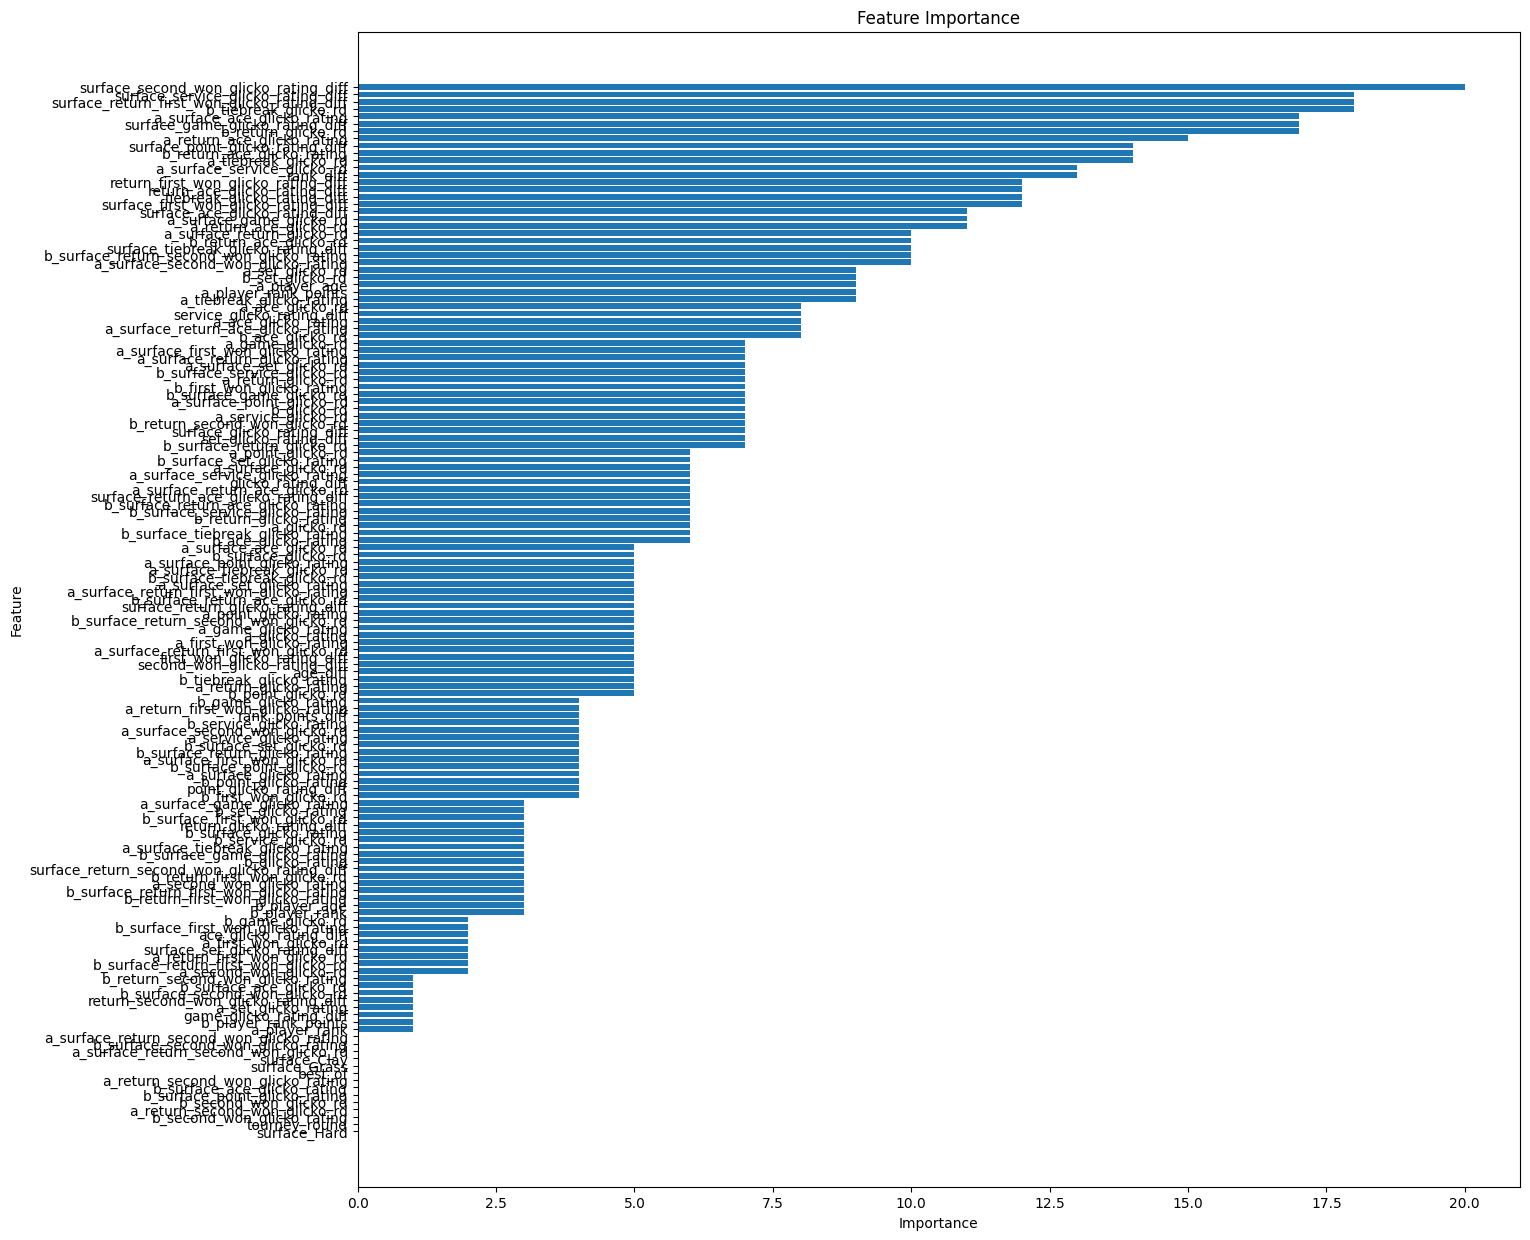

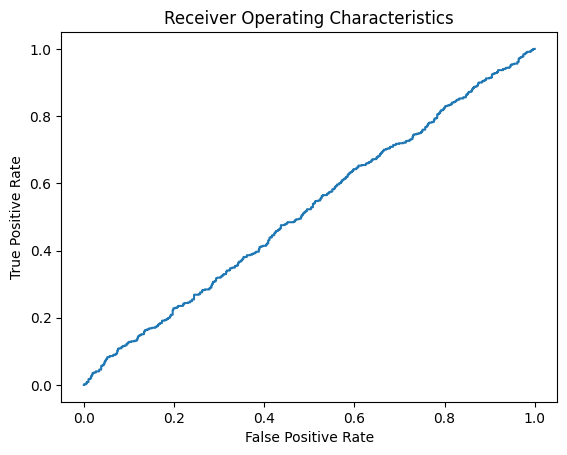

In [9]:
# Data cleaning
df = df.dropna()
df = df[~(df == 0.5).any(axis=1)]
# df = df[(df['surface_Clay'] == 1.0)]


# Extract and manage odds columns
odds_df = df[['a_odds', 'b_odds']].copy()
odds_df['index'] = df.index
df = df.drop(columns=['a_odds', 'b_odds'])


# df = df[df.columns[df.columns.str.contains('surface') | df.columns.str.contains('games')]]
# Split the data into features and target
y = df['games'].values
X = df.drop('games', axis=1).values


# Split the data into training and testing sets
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, odds_df['index'].values, test_size=0.2, random_state=42
)

# Split the training set further into training and validation sets
X_train, X_validate, y_train, y_validate = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Convert back to DataFrames to match your trainModel function expectations
df_train = pd.DataFrame(X_train, columns=df.columns.drop('games'))
df_train['Result'] = y_train

df_validate = pd.DataFrame(X_validate, columns=df.columns.drop('games'))
df_validate['Result'] = y_validate

df_test = pd.DataFrame(X_test, columns=df.columns.drop('games'))
df_test['Result'] = y_test

# List of features you want to use for training
selected_features = df_train.columns.drop('Result').tolist()  # This includes all features except the target column

# Train the model
model = trainModel(selected_features, df_train, df_validate, df_test)

# Evaluate the model
evaluation_metrics = evaluateModel(model, df_test, selected_features)

# Print evaluation results
print(f"Accuracy: {evaluation_metrics['accuracy']:.4f}")
print(f"AUC: {evaluation_metrics['auc']:.4f}")

importances = model.feature_importance()

# Create a DataFrame for the feature importances
feature_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(15, 15))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # To have the most important features on top
plt.show()

# Optionally, save the model to a file
model.save_model('lightgbm_model.txt')

# Predict using LightGBM model
y_pred = model.predict(X_test)

# Ensure odds are correctly indexed
odds_test = odds_df.loc[idx_test].values

# Create DataFrame with predictions and actual values
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'A_Odds': odds_test[:, 0],
    'B_Odds': odds_test[:, 1]
})

# Optionally save to CSV
results_df.to_csv('predictions_with_odds.csv', index=False)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.title("Receiver Operating Characteristics")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [10]:
# Display the DataFrame
# results_df.head()
print(results_df)

      Actual  Predicted  A_Odds  B_Odds
0        1.0   0.397042    1.75    2.04
1        0.0   0.522356    1.61    2.28
2        0.0   0.383775    2.76    1.43
3        1.0   0.436391    1.24    3.95
4        1.0   0.442152    1.38    2.97
...      ...        ...     ...     ...
1240     0.0   0.441441    5.74    1.13
1241     0.0   0.322441    9.01    1.06
1242     0.0   0.472335    1.24    3.90
1243     0.0   0.467506    1.67    2.16
1244     1.0   0.400304    1.25    3.83

[1245 rows x 4 columns]


In [11]:
# Kelly Criterion
def kelly_criterion(vegas_odds, calculated_probability):
    corrected = vegas_odds - 1
    # Calculate the Kelly fraction
    kelly_fraction = calculated_probability - ((1 - calculated_probability)/corrected)
    # Ensure that the fraction is not negative
    kelly_fraction = max(0, kelly_fraction)
    
    return kelly_fraction

In [12]:
better = 0
bet_correct = 0

model_correct = 0

wrong = 0
comparison_df = results_df.dropna()
length = len(comparison_df)

confidence_pct = .6
confidence_top_pct = 1

avg_bet = 0

OVER = 1.88
UNDER = 1.85

START_UNIT = 60
UNIT = START_UNIT

for i, row in comparison_df.iterrows():
    temp = START_UNIT
    if confidence_top_pct > row['Predicted'] > confidence_pct :
        kelly = (kelly_criterion(OVER, row['Predicted']) * START_UNIT)
        better += 1 if kelly > 0 else 0
        avg_bet += kelly_criterion(OVER, row['Predicted'])
        if(row['Actual'] == 1):
            bet_correct += 1 if kelly > 0 else 0
            START_UNIT += (OVER-1) * kelly
        else:
            wrong += 1
            START_UNIT -= kelly

    if 1-confidence_top_pct < row['Predicted'] < 1-confidence_pct :
        kelly = (kelly_criterion(UNDER, 1-row['Predicted']) * START_UNIT)
        better += 1 if kelly > 0 else 0
        avg_bet += kelly_criterion(UNDER, 1-row['Predicted'])
        if(row['Actual'] == 0):
            bet_correct += 1 if kelly > 0 else 0
            START_UNIT += (UNDER-1) * kelly
        else:
            wrong += 1
            START_UNIT -= kelly

    # if kelly > 0:
    #     print(f"Start : {temp} Kelly {kelly}")
    # kelly = 0

    if round(row['Predicted']) == round(row['Actual']):
        model_correct += 1


print(f"Total won on Starting ${UNIT} bankroll: ${START_UNIT:.2f} on a total # bets: {better} from a total of {length} games")
print(f"ROI : {((START_UNIT-UNIT)/UNIT):.1f} X")
print(f"Avg Bankroll Bet Percent {(avg_bet/better):.3f} %")
print(f"Amount of incorrect bet % : {(wrong/better):.4f}")
print(f"Correct Bet %: {(bet_correct/better):.4f}")
print(f"Model % Correct : {(model_correct/length):.4f}")


Total won on Starting $60 bankroll: $0.02 on a total # bets: 339 from a total of 1245 games
ROI : -1.0 X
Avg Bankroll Bet Percent 0.249 %
Amount of incorrect bet % : 0.4513
Correct Bet %: 0.5487
Model % Correct : 0.5349
